## Introduction

This is an open-source implementation of the paper **Hiding Images in Plain Sight: Deep Steganography, by Shumeet Baluja (Google), at NIPS 2017**. The paper is available [here](https://papers.nips.cc/paper/6802-hiding-images-in-plain-sight-deep-steganography).

This code was initially produced with the goal of reproducing to a reasonable degree the results achieved and described in the paper, for the **[Global NIPS Paper Implementation Challenge](https://nurture.ai/nips-challenge/)**.

**Abstract**: Steganography is the practice of concealing a secret message within another, ordinary, message. Commonly, steganography is used to unobtrusively hide a small message within the noisy regions of a larger image. In this study, we attempt to place a full size color image within another image of the same size. Deep neural networks are simultaneously trained to create the hiding and revealing processes and are designed to specifically work as a pair. The system is trained on images drawn randomly from the ImageNet database, and works well on natural images from a wide variety of sources. Beyond demonstrating the successful application of deep learning to hiding images, we carefully examine how the result is achieved and explore extensions. Unlike many popular steganographic methods that encode the secret message within the least significant bits of the carrier image, our approach compresses and distributes the secret image's representation across all of the available bits.

In [27]:
### Imports ###
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.engine.topology import Container
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

## Config

In [28]:
### Constants ###
DATA_DIR = "./data"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)

## Dataset creation
The Dataset we used is Tiny ImageNet Visual Recognition Challenge. It can be downloaded [here](https://tiny-imagenet.herokuapp.com/).

Our training set is made of a random subset of images from all 200 classes.

In [152]:
def load_dataset_small(num_images_per_class_train=10, num_images_test=500):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:num_images_test]:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)

In [153]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 2000
Number of test examples = 2000
X_train shape: (2000, 64, 64, 3)


In [128]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.

# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

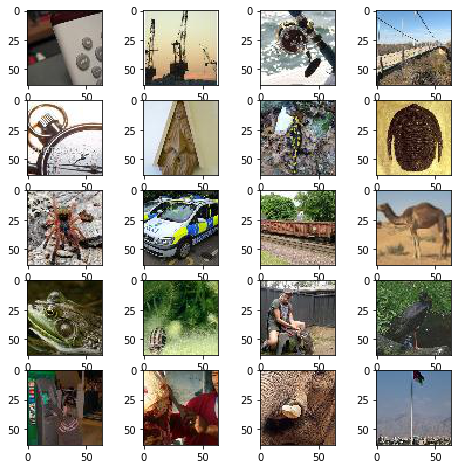

In [165]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

## Model

The model is composed of three parts: The **Preparation Network**, **Hiding Network** (Encoder) and the **Reveal Network**. Its goal is to be able to encode information about the secret image S into the cover image C, generating C' that closely resembles C, while still being able to decode information from C' to generate the decoded secret image S', which should resemble S as closely as possible.

The Preparation Network has the responsibility of preparing data from the secret image to be concatenated with the cover image and fed to the Hiding Network. The Hiding Network than transforms that input into the encoded cover image C'. Finally, the Reveal Network decodes the secret image S' from C'. For stability, we add noise before the Reveal Network, as suggested by the paper. Although the author of the paper didn't originally specify the architecture of the three networks, we discovered aggregated layers showed good results. For both the Hiding and Reveal networks, we use 5 layers of 65 filters (50 3x3 filters, 10 4x4 filters and 5 5x5 filters). For the preparation network, we use only 2 layers with the same structure.

Note that the loss function for the Reveal Network is different from the loss function for the Preparation and Hiding Networks. In order to correctly implement the updates for the weights in the networks, we create stacked Keras models, one for the Preparation and Hiding Network (which share the same loss function) and one for the Reveal Network. To make sure weights are updated only once, we freeze the weights on the layers of the Reveal Network before adding it to the full model.

![](_images/network.png)

In [112]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
    
    s_loss = rev_loss(s_true, s_pred)
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    else:
        return Container(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    
    return encoder, decoder, autoencoder

In [113]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])

## Training

Although the author of the paper didn't explicitly described the learning rate schedule or the optimizer properties, we used our own schedule with ADAM optimizer. We train for 1000 epochs with a batch size of 32. 

In [116]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [ ]:
NB_EPOCHS = 1000
BATCH_SIZE = 32

m = input_S.shape[0]
loss_history = []
for epoch in range(NB_EPOCHS):
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss = []
    for idx in t:
        
        batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                   y=np.concatenate((batch_S, batch_C),axis=3)))
        rev_loss.append(reveal_model.train_on_batch(x=C_prime,
                                              y=batch_S))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
    loss_history.append(np.mean(ae_loss))


  0%|          | 0/32 [00:00<?, ?it/s]
Exception in thread Thread-340:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

/home/paperspace/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
Epoch 1 | Batch: 992 of 1000. Loss AE   64388.77 | Loss Rev   31988.86: 100%|██████████| 32/32 [00:44<00:00,  1.38s/it]
Epoch 2 | Batch: 992 of 1000. Loss AE   34346.80 | 

Epoch 128 | Batch: 992 of 1000. Loss AE    2551.69 | Loss Rev    1432.74: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 129 | Batch: 992 of 1000. Loss AE    2761.44 | Loss Rev    1588.11: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 130 | Batch: 992 of 1000. Loss AE    2303.50 | Loss Rev    1170.16: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 131 | Batch: 992 of 1000. Loss AE    4446.53 | Loss Rev    2911.89: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 132 | Batch: 992 of 1000. Loss AE    2758.67 | Loss Rev    1467.46: 100%|██████████| 32/32 [00:29<00:00,  1.07it/s]
Epoch 133 | Batch: 992 of 1000. Loss AE    2354.69 | Loss Rev    1234.97: 100%|██████████| 32/32 [00:30<00:00,  1.07it/s]
Epoch 134 | Batch: 992 of 1000. Loss AE    4378.84 | Loss Rev    2796.94: 100%|██████████| 32/32 [00:29<00:00,  1.07it/s]
Epoch 135 | Batch: 992 of 1000. Loss AE    2396.02 | Loss Rev    1182.14: 100%|██████████| 32/32 [00:30<00:00,  1.07it/s]
Epoch 136 | Batch: 992 o

Epoch 264 | Batch: 992 of 1000. Loss AE    1586.19 | Loss Rev     675.28: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 265 | Batch: 992 of 1000. Loss AE    1612.76 | Loss Rev     699.60: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 266 | Batch: 992 of 1000. Loss AE    1575.14 | Loss Rev     677.17: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 267 | Batch: 992 of 1000. Loss AE    1662.98 | Loss Rev     738.76: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 268 | Batch: 992 of 1000. Loss AE    1653.12 | Loss Rev     700.23: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 269 | Batch: 992 of 1000. Loss AE    1609.87 | Loss Rev     692.84: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 270 | Batch: 992 of 1000. Loss AE    1750.20 | Loss Rev     820.38: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 271 | Batch: 992 of 1000. Loss AE    1605.44 | Loss Rev     669.33: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 272 | Batch: 992 o

Epoch 403 | Batch: 992 of 1000. Loss AE    1354.44 | Loss Rev     521.94: 100%|██████████| 32/32 [00:30<00:00,  1.07it/s]
Epoch 404 | Batch: 992 of 1000. Loss AE    1347.54 | Loss Rev     528.47: 100%|██████████| 32/32 [00:30<00:00,  1.07it/s]
Epoch 405 | Batch: 992 of 1000. Loss AE    1345.45 | Loss Rev     528.00: 100%|██████████| 32/32 [00:30<00:00,  1.07it/s]
Epoch 406 | Batch: 992 of 1000. Loss AE    1340.65 | Loss Rev     524.90: 100%|██████████| 32/32 [00:30<00:00,  1.07it/s]
Epoch 407 | Batch: 992 of 1000. Loss AE    1330.84 | Loss Rev     527.73: 100%|██████████| 32/32 [00:30<00:00,  1.07it/s]
Epoch 408 | Batch: 992 of 1000. Loss AE    1332.92 | Loss Rev     527.72: 100%|██████████| 32/32 [00:30<00:00,  1.07it/s]
Epoch 409 | Batch: 992 of 1000. Loss AE    1342.83 | Loss Rev     530.22: 100%|██████████| 32/32 [00:30<00:00,  1.07it/s]
Epoch 410 | Batch: 992 of 1000. Loss AE    1330.91 | Loss Rev     528.28: 100%|██████████| 32/32 [00:30<00:00,  1.07it/s]
Epoch 411 | Batch: 992 o

Epoch 537 | Batch: 992 of 1000. Loss AE    1280.89 | Loss Rev     516.01: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 538 | Batch: 992 of 1000. Loss AE    1276.54 | Loss Rev     523.75: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 539 | Batch: 992 of 1000. Loss AE    1271.70 | Loss Rev     520.60: 100%|██████████| 32/32 [00:30<00:00,  1.07it/s]
Epoch 540 | Batch: 992 of 1000. Loss AE    1299.79 | Loss Rev     534.03: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 541 | Batch: 992 of 1000. Loss AE    1282.33 | Loss Rev     521.48: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 542 | Batch: 992 of 1000. Loss AE    1286.97 | Loss Rev     518.31: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 543 | Batch: 992 of 1000. Loss AE    1278.60 | Loss Rev     521.97: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 544 | Batch: 992 of 1000. Loss AE    1271.14 | Loss Rev     509.31: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 545 | Batch: 992 o

Epoch 677 | Batch: 992 of 1000. Loss AE    1240.47 | Loss Rev     504.47: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 678 | Batch: 992 of 1000. Loss AE    1229.97 | Loss Rev     503.01: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 679 | Batch: 992 of 1000. Loss AE    1229.43 | Loss Rev     505.35: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 680 | Batch: 992 of 1000. Loss AE    1228.43 | Loss Rev     496.33: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 681 | Batch: 992 of 1000. Loss AE    1225.11 | Loss Rev     495.94: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 682 | Batch: 992 of 1000. Loss AE    1227.16 | Loss Rev     494.20: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 683 | Batch: 992 of 1000. Loss AE    1222.99 | Loss Rev     498.53: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 684 | Batch: 992 of 1000. Loss AE    1228.60 | Loss Rev     500.48: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 685 | Batch: 992 o

Epoch 811 | Batch: 992 of 1000. Loss AE    1207.59 | Loss Rev     490.06: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 812 | Batch: 992 of 1000. Loss AE    1214.25 | Loss Rev     491.92: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 813 | Batch: 992 of 1000. Loss AE    1204.15 | Loss Rev     492.55: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 814 | Batch: 992 of 1000. Loss AE    1213.79 | Loss Rev     492.19: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 815 | Batch: 992 of 1000. Loss AE    1203.76 | Loss Rev     490.07: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 816 | Batch: 992 of 1000. Loss AE    1212.89 | Loss Rev     492.00: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 817 | Batch: 992 of 1000. Loss AE    1209.68 | Loss Rev     491.21: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 818 | Batch: 992 of 1000. Loss AE    1203.80 | Loss Rev     491.49: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 819 | Batch: 992 o

Epoch 945 | Batch: 992 of 1000. Loss AE    1191.21 | Loss Rev     486.12: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 946 | Batch: 992 of 1000. Loss AE    1190.98 | Loss Rev     484.69: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 947 | Batch: 992 of 1000. Loss AE    1185.22 | Loss Rev     486.99: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 948 | Batch: 992 of 1000. Loss AE    1192.70 | Loss Rev     487.06: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 949 | Batch: 992 of 1000. Loss AE    1187.93 | Loss Rev     485.69: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 950 | Batch: 992 of 1000. Loss AE    1192.17 | Loss Rev     486.85: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 951 | Batch: 992 of 1000. Loss AE    1188.48 | Loss Rev     486.86: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 952 | Batch: 992 of 1000. Loss AE    1191.01 | Loss Rev     487.89: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
Epoch 953 | Batch: 992 o

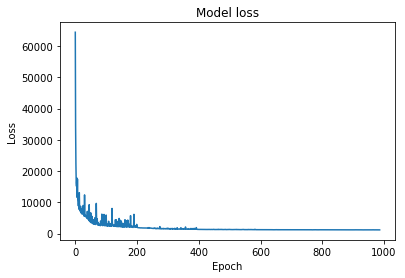

In [166]:
# Plot loss through epochs
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [125]:
# Save model
# autoencoder_model.save_weights('models/model.hdf5')

In [ ]:
# Load model
# autoencoder_model.load_weights('models/model.hdf5')

## Results

In [130]:
# Retrieve decoded predictions.
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C) 

In [131]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_Spixel, see_Cpixel

def pixel_histogram(diff_S, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,2,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, normed=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(255* diff_Sflat, 100, normed=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image.')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()

In [132]:
# Print pixel-wise average errors in a 256 scale.
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 6.90877
C error per pixel [0, 255]: 10.7178


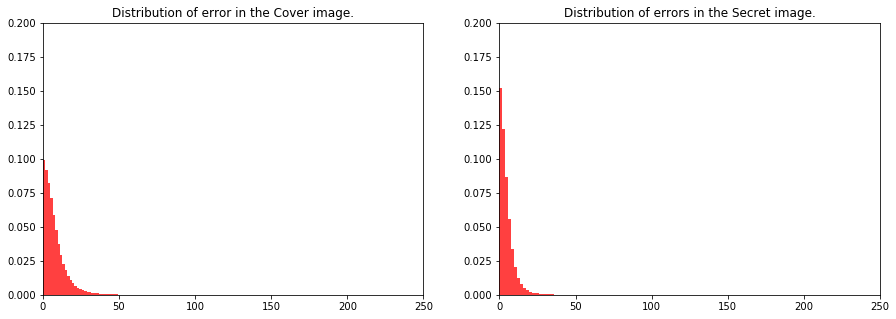

In [133]:
# Plot distribution of errors in cover and secret images.
pixel_histogram(diff_S, diff_C)

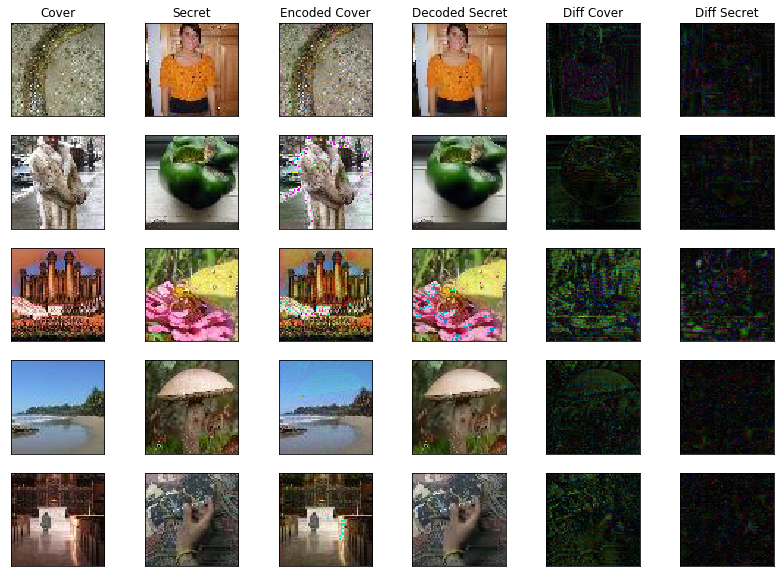

In [167]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 3

# Number of secret and cover pairs to show.
n = 5

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 10))
rand_indx = [random.randint(0, 1000) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')

    
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()